In [27]:
import time
import pickle

import numpy as np

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from utils import *
from q_learning import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Configurations
save_stats = True
save_figs = False
load = False

seed = 0

## 2. Q-Learning

In [30]:
env = TictactoeEnv()

# Hyper-parameters
alpha = 0.05    # Learning rate
gamma = 0.99    # Discount factor
epsilon_opt = 0.5   # Optimal player's epsilon
num_episodes = 20000
num_avg = 2

### 2.1 Learning from experts

In [31]:
var_name = 'eps'
epsilon_vec = [0.1]
q_learning_params_list = []
for eps in epsilon_vec:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration': eps,
              'test_freq': 250,
              'against_opt': True}
    q_learning_params_list.append(params)

In [33]:
stats_dict_eps_list = train_avg(var_name, epsilon_vec, q_learning_params_list, num_avg = num_avg, save_stats = save_stats)

************** RUN 1 OF 2 **************
------------- Training with eps = 0.1 -------------
M_opt = -0.256
M_rand = 0.79
Training with eps = 0.1  took: 00h03m19s 


************** RUN 2 OF 2 **************
------------- Training with eps = 0.1 -------------
M_opt = 0.0
M_rand = 0.818
Training with eps = 0.1  took: 00h03m16s 




epsilon = 0.1 : 	M_opt =  -0.128 	M_rand =  0.804


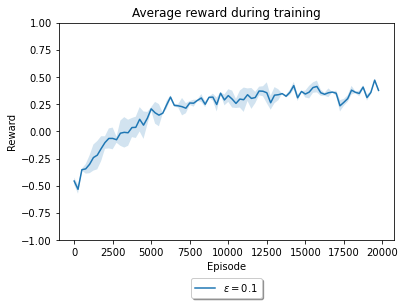

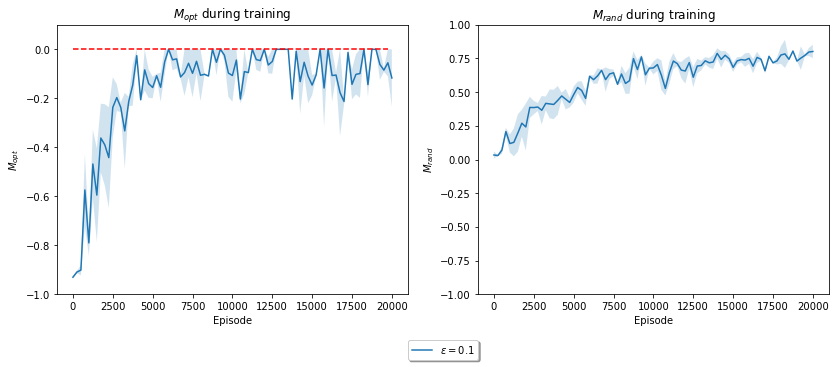

In [34]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_eps_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps_list = pickle.load(handle)

plot_stats(stats_dict_eps_list, epsilon_vec, "epsilon", "\epsilon", save=save_figs, std=True)

#### Question 1: Average reward with $\epsilon = 0.1$

In [5]:
epsilon_exploration = 0.1
rewards_list = []
for i in range(num_avg):
    Q, stats = q_learning(env, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, verbose=False, against_opt=True)
    rewards_list.append(stats['rewards'])

46.59989356994629


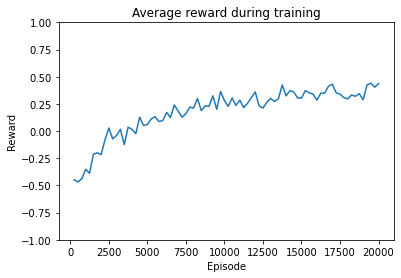

0.9677562713623047

----- Trained  player-----
2.49979305267334
M_opt =  0.0
M_rand =  0.848
M_teacher =  0.56

----- Optimal  player-----
3.2261502742767334
M_opt =  0.0
M_rand =  0.922
M_teacher =  0.618

----- Random  player-----
1.422598123550415
M_opt =  -0.922
M_rand =  0.044
M_teacher =  -0.602


In [7]:
# Plotting the average reward for every 250 games during training
running_rewards_list = []
for reward in rewards_list:
    running_average_rewards, x = running_average(reward)
    running_rewards_list.append(running_average_rewards)

running_average_rewards = np.mean(running_rewards_list, axis=0)
stds = np.std(running_rewards_list, axis=0)
fig = plt.figure()
plt.plot(x, running_average_rewards)
plt.fill_between(x, running_average_rewards - stds, running_average_rewards + stds, alpha=0.2)
plt.ylim([-1,1])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Average reward during training')
plt.show()
if save_figs:
        output_folder = os.path.join(os.getcwd(), 'figures')
        os.makedirs(output_folder, exist_ok=True)
        fig.savefig(output_folder + '/rewards_Q1.png')
        fig.savefig(output_folder + '/rewards_Q1.eps', format = 'eps')

# Comparing the performance with the optimal player and the random player
turns = np.array(['X','O'])
player_opt = OptimalPlayer(epsilon=0.)
player_rand = OptimalPlayer(epsilon=1.)
teacher = OptimalPlayer(epsilon=0.5)

names = ['Trained', 'Optimal', 'Random']
players = [QPlayer(Q=Q), OptimalPlayer(epsilon=0.), OptimalPlayer(epsilon=1.)]

for (name, player) in zip(names, players):
    print("\n-----", name, " player-----")
    start = time.time()
    m_opt = measure_performance(player, player_opt)
    print(time.time() - start)
    print("M_opt = ", m_opt)
    m_rand = measure_performance(player, player_rand)
    print("M_rand = ", m_rand)
    m_teacher = measure_performance(player, teacher)
    print("M_teacher = ", m_teacher)

#### Questions 2 and 3: Decreasing exploration for different values of $n^{*}$

In [24]:
test_freq = 250
epsilon_min = 0.1
epsilon_max = 0.8
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))
vec_n_star = [1]

num_avg = 2
save_stats = True
load = False

In [25]:
if not load:
    stats_dict_nstar_list = []
    for i in range(num_avg):
        print('************** RUN', i+1, 'OF', num_avg, '**************')
        stats_dict_nstar = {}
        for n_star in vec_n_star:
            print("------------- Training with n_star =", n_star, "-------------")
            def epsilon_exploration_rule(n):
                return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
            start = time.time()
            Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, test_freq=test_freq, against_opt=True)
            M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
            M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
            print("M_opt =", M_opt)
            print("M_rand =", M_rand)
            stats_dict_nstar.update({n_star: (stats, M_opt, M_rand)})
            elapsed = time.time() - start
            print("Training with n_star =", n_star, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), "\n\n")
        stats_dict_nstar_list.append(stats_dict_nstar)

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_nstar_list.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_nstar_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

************** RUN 1 OF 2 **************
------------- Training with n_star = 1 -------------
M_opt = -0.098
M_rand = 0.7295
Training with n_star = 1  took: 00h03m28s 


************** RUN 2 OF 2 **************
------------- Training with n_star = 1 -------------
M_opt = 0.0
M_rand = 0.646
Training with n_star = 1  took: 00h03m27s 




n_star_first = 1.0 : 	M_opt =  -0.049 	M_rand =  0.6877500000000001


KeyError: 24460.0

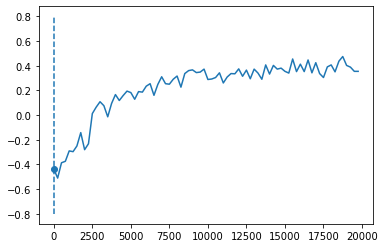

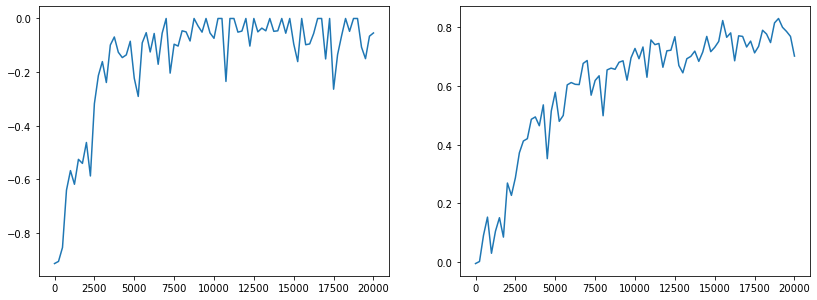

In [26]:
load = True
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_list = pickle.load(handle)

plot_n_star = [1., 24460., 40000]
plot_stats(stats_dict_nstar_list, plot_n_star, 'n_star_first', "n^{\star}", save=True, decaying_exploration=True)

plot_n_star = [1., 4373., 9146.]
plot_stats(stats_dict_nstar_list, plot_n_star, 'n_star_second', "n^{\star}", save=True, decaying_exploration=True)
# plot_stats(stats_dict_nstar, vec_n_star, 'n_star', "n^{\star}", save=False)

#### Questions 4 and 5: Good experts and bad experts

In [12]:
n_star = 4000 # this should be picked from before not inserted manually
M = 11
vec_epsilon_opt = np.linspace(0, 1, M)

In [ ]:
if not load:
    stats_dict_nstar_list = []
    for i in range(num_avg):
        print('************** RUN', i+1, 'OF', num_avg, '**************')
        stats_dict_nstar = {}
        for n_star in vec_n_star:
            print("------------- Training with n_star =", n_star, "-------------")
            def epsilon_exploration_rule(n):
                return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
            start = time.time()
            Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, test_freq=test_freq, against_opt=True)
            M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
            M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
            print("M_opt =", M_opt)
            print("M_rand =", M_rand)
            stats_dict_nstar.update({n_star: (stats, M_opt, M_rand)})
            elapsed = time.time() - start
            print("Training with n_star =", n_star, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), "\n\n")
        stats_dict_nstar_list.append(stats_dict_nstar)

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_nstar_list.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_nstar_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
if not load:
    stats_dict_epsilon_opt = {}
    for epsilon_opt in vec_epsilon_opt:
        print("------------- Training with epsilon_opt =", epsilon_opt, "-------------")
        start = time.time()
        Q, stats = q_learning(env, epsilon_opt=epsilon_opt, test_freq=test_freq, against_opt=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_epsilon_opt.update({epsilon_opt: (stats, M_opt, M_rand)})
        elapsed = time.time() - start
        print("Training with epsilon_opt =", epsilon_opt, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_epsilon_opt.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_epsilon_opt, handle, protocol=pickle.HIGHEST_PROTOCOL)

epsilon_opt = 0.0 : 	M_opt =  0.0 	M_rand =  0.191
epsilon_opt = 0.5 : 	M_opt =  -0.098 	M_rand =  0.711
epsilon_opt = 1.0 : 	M_opt =  -0.264 	M_rand =  0.828


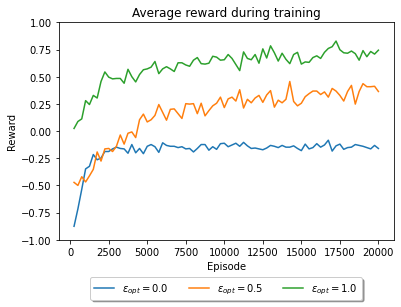

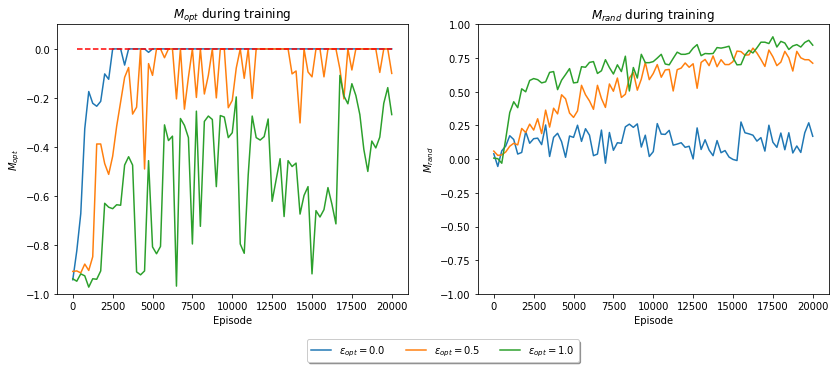

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [14]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_epsilon_opt.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_epsilon_opt = pickle.load(handle)

plot_epsilon_opt = [0., 0.5, 1.]
plot_stats(stats_dict_epsilon_opt, plot_epsilon_opt, "epsilon_opt", "\epsilon_{opt}", save=True)
# plot_stats(stats_dict_epsilon_opt, vec_epsilon_opt, "epsilon_opt", "\epsilon_{opt}", save=False)

### 2.2 Learning by self-practice

#### Question 7: Self-learning with constant rate of exploration $\epsilon$

In [12]:
epsilon_vec = np.array([0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])
#epsilon_vec = np.hstack((epsilon_vec_plot, np.setdiff1d(np.logspace(-4, -1, 10), epsilon_vec_plot)))
len(epsilon_vec)

10

In [16]:
if not load:
    env = TictactoeEnv()
    stats_dict_eps_self = {}
    for epsilon in epsilon_vec:
        print("------------- Training with epsilon =", epsilon, "-------------")
        Q, stats = q_learning(env, num_episodes=num_episodes,
                            epsilon_exploration=epsilon, test_freq = 250, verbose=False, self_practice=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_eps_self.update({epsilon: (stats, M_opt, M_rand)})

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_eps_self.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_eps_self, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_eps_self.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps_self = pickle.load(handle)

epsilon_vec_plot = [0, 0.001, 0.01, 0.1]
plot_stats(stats_dict_eps_self, epsilon_vec_plot, "epsilon_self", "\epsilon", save=save_figs)
plot_stats(stats_dict_eps_self, epsilon_vec, "epsilon_self", "\epsilon", save=False)

epsilon_self = 0 : 	M_opt =  -0.942 	M_rand =  0.264
epsilon_self = 0.001 : 	M_opt =  -0.5345 	M_rand =  0.595
epsilon_self = 0.01 : 	M_opt =  -0.228 	M_rand =  0.7715
epsilon_self = 0.1 : 	M_opt =  0.0 	M_rand =  0.8875


#### Question 8: Decaying exploration rule for different values of $n^*$

In [7]:
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))
epsilon_min = 0.1
epsilon_max = 0.8

In [8]:
if not load:
    stats_dict_nstar_self = {}
    for n_star in vec_n_star:
        print("------------- Training with n_star =", n_star, "-------------")
        def epsilon_exploration_rule(n):
            return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
        start = time.time()
        Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule,
                                test_freq=test_freq,  num_episodes=num_episodes, verbose=False, self_practice=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=200)
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=200)
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict_nstar_self.update({n_star: (stats, M_opt, M_rand)})
        elapsed = time.time() - start
        print("Training with n_star =", n_star, "took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), "\n\n")

    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/stats_dict_nstar_self.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_nstar_self, handle, protocol=pickle.HIGHEST_PROTOCOL)

------------- Training with n_star = 1.0 -------------
M_opt = 0.0
M_rand = 0.955
Training with n_star = 1.0 took: 00h02m40s 


------------- Training with n_star = 100.0 -------------
M_opt = -0.13
M_rand = 0.9
Training with n_star = 100.0 took: 00h02m41s 


------------- Training with n_star = 500.0 -------------
M_opt = 0.0
M_rand = 0.94
Training with n_star = 500.0 took: 00h02m34s 


------------- Training with n_star = 750.0 -------------
M_opt = 0.0
M_rand = 0.945
Training with n_star = 750.0 took: 00h02m35s 


------------- Training with n_star = 1000.0 -------------
M_opt = 0.0
M_rand = 0.905
Training with n_star = 1000.0 took: 00h02m34s 


------------- Training with n_star = 1279.0 -------------
M_opt = 0.0
M_rand = 0.895
Training with n_star = 1279.0 took: 00h02m34s 


------------- Training with n_star = 1635.0 -------------
M_opt = 0.0
M_rand = 0.905
Training with n_star = 1635.0 took: 00h02m34s 


------------- Training with n_star = 2091.0 -------------
M_opt = 0.0
M_ran

n_star_self_1 = 1.0 : 	M_opt =  0.0 	M_rand =  0.955
n_star_self_1 = 4373.0 : 	M_opt =  0.0 	M_rand =  0.915
n_star_self_1 = 24460.0 : 	M_opt =  -0.085 	M_rand =  0.95
n_star_self_1 = 40000 : 	M_opt =  -0.27 	M_rand =  0.82


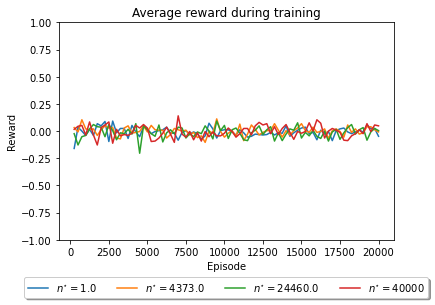

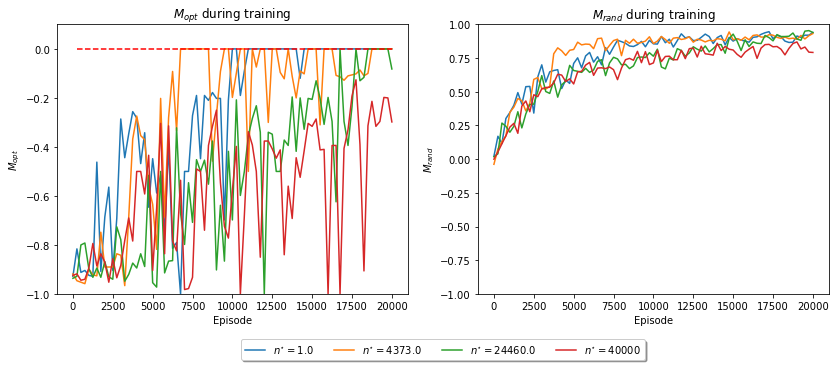

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


n_star_self_2 = 1.0 : 	M_opt =  0.0 	M_rand =  0.955
n_star_self_2 = 4373.0 : 	M_opt =  0.0 	M_rand =  0.915
n_star_self_2 = 9146.0 : 	M_opt =  -0.095 	M_rand =  0.905


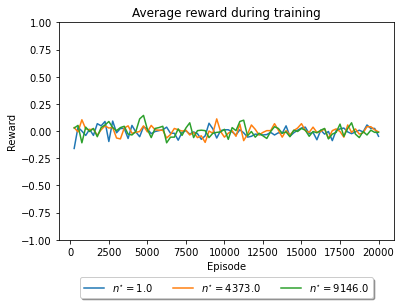

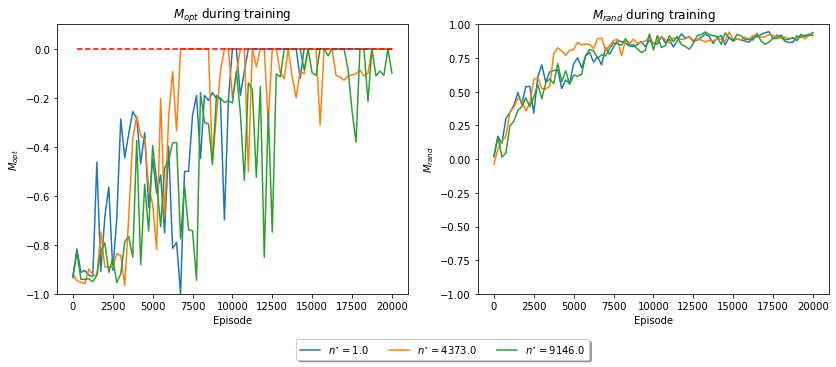

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


n_star = 1.0 : 	M_opt =  0.0 	M_rand =  0.955
n_star = 100.0 : 	M_opt =  -0.13 	M_rand =  0.9
n_star = 500.0 : 	M_opt =  0.0 	M_rand =  0.94
n_star = 750.0 : 	M_opt =  0.0 	M_rand =  0.945
n_star = 1000.0 : 	M_opt =  0.0 	M_rand =  0.905
n_star = 1279.0 : 	M_opt =  0.0 	M_rand =  0.895
n_star = 1635.0 : 	M_opt =  0.0 	M_rand =  0.905
n_star = 2091.0 : 	M_opt =  0.0 	M_rand =  0.935
n_star = 2674.0 : 	M_opt =  -0.125 	M_rand =  0.91
n_star = 3420.0 : 	M_opt =  0.0 	M_rand =  0.885
n_star = 4373.0 : 	M_opt =  0.0 	M_rand =  0.915
n_star = 5593.0 : 	M_opt =  -0.2 	M_rand =  0.925
n_star = 7152.0 : 	M_opt =  -0.145 	M_rand =  0.93
n_star = 9146.0 : 	M_opt =  -0.095 	M_rand =  0.905
n_star = 11696.0 : 	M_opt =  -0.115 	M_rand =  0.92
n_star = 14957.0 : 	M_opt =  0.0 	M_rand =  0.895
n_star = 19127.0 : 	M_opt =  0.0 	M_rand =  0.905
n_star = 24460.0 : 	M_opt =  -0.085 	M_rand =  0.95
n_star = 31279.0 : 	M_opt =  -0.135 	M_rand =  0.85
n_star = 40000.0 : 	M_opt =  -0.27 	M_rand =  0.82


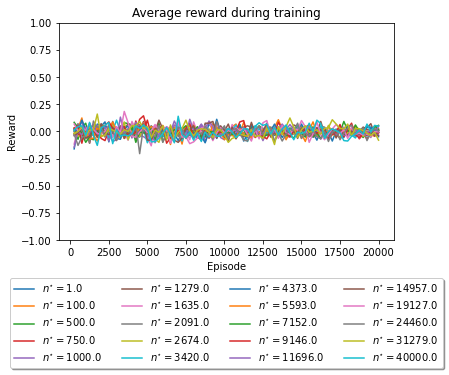

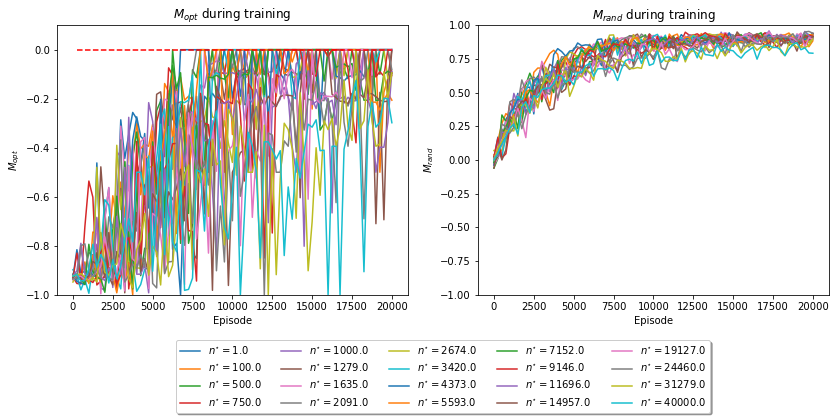

In [10]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar_self.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_self = pickle.load(handle)

plot_n_star = [1., 4373., 24460., 40000]
plot_stats(stats_dict_nstar_self, plot_n_star, 'n_star_self_1', "n^{\star}", save=save_figs)

plot_n_star = [1., 4373., 9146.]
plot_stats(stats_dict_nstar_self, plot_n_star, 'n_star_self_2', "n^{\star}", save=save_figs)
plot_stats(stats_dict_nstar_self, vec_n_star, 'n_star', "n^{\star}", save=False)

#### Question 10: Heatmaps of the Q-values in 3 significant states

In [52]:
# Parametri ottimali di Q
np.random.seed(seed)
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 4373
def epsilon_exploration_rule(n):
            return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, num_episodes=20000, verbose=True, self_practice=True)

In [53]:
grids = [[1., 0., 0., -1., 1., 0., 0., -1., 0.], [-1., 0., 0., 1., -1., 0., 0., 1., 0.], [1., -1., 0., 0., 0., 0., 0., 0., 0.]]
heatmaps_subplots(grids, Q)

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Remove

## Deep Q-Learning